# Classifying Handwritten Digits
Now that we can create a basic neural network, let’s use a more realistic dataset and tackle an image classification problem. For this task, we will use a dataset popularized by Yann LeCun, which contains 70,000 examples of handwritten digits, called MNIST (Modified National Institute of Standards and Technology) database. This dataset has been widely used for image processing and classification. A few digits are shown below:

![digits-from-mnist](images/digits-from-mnist.png)

Let's import the required libraries. For this program, in addition to torchvision, which is a part of PyTorch and provides various datasets, models, and image transformations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

Before we download the dataset programmatically, we can define a list of transforms that must be applied to help us process the dataset. We will need to convert the images to tensor format. We can use torchvision.datasets() to download the dataset. The files will be exported to “/train/MNIST/raw” and “/test/MNIST/raw” folders.

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('train', download=True, train=True, transform=transform)

testset = datasets.MNIST('test', download=True, train=False, transform=transform)

The next two lines initialize a DataLoader item for both training data and test data. DataLoader doesn’t directly provide the data but can be controlled by a user-defined iterable.

In [3]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [4]:
trainset.data.numpy().max()

255

In [5]:
testset.data.shape

torch.Size([10000, 28, 28])

In [6]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Before we define a neural network, let’s look at a data item. The following lines would generate a batch of training data of 64 elements.

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [8]:
# After you call the dataloader the tranform functions are called, which also scale the values from (0->255) to (0->1)
images[8].numpy().max()

1.0

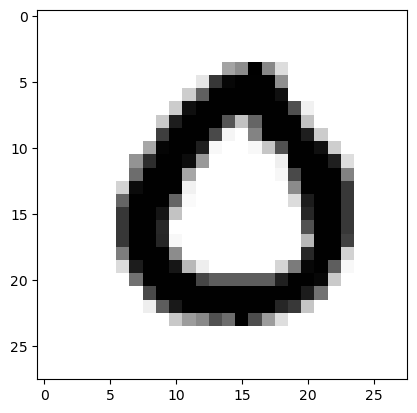

In [9]:
# Squeeze to remove one dimension
plt.imshow(images[8].numpy().squeeze(), cmap='gray_r')

Each digit is present in a 28x28 pixel box. Each pixel, in this grayscale dataset, contains a value from 0 (darkest) to 255 (whitest) indicating the color (in terms of darkness). Thus, each image is defined by 784 (28x28) values.

Now we can proceed to defining the network. We know that the input layer contains 784 units and the output layer contains 10 units, each representing a number. We will add two more input layers with 64 units each. For this example, we will keep activations as ReLU, and because we have a multiclass classification problem, loss layer will be `cross-entropy`. Image below summarizes the neural network we will be creating in this example.

![nn-for-mnist](images/nn-for-mnist.png)

In [10]:
model = nn.Sequential(nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,10),
        )

model

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

In [11]:
# We now define the loss function and the optimizer.
lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.01)

In the training phase, we will limit the number of epochs to ten, as the dataset is much larger than the examples we’ve covered so far. However, this should be good enough to bring the losses sufficiently low to make the model able to predict well for most of the examples. Within each epoch, train_loader would iterate over batches of 64 entries.

## Calculate the loss

In [12]:
train_losses = []
test_losses = []
epoch_count = 10

for epoch in range(epoch_count):
    running_loss = 0
    epoch_train_loss = []
    epoch_test_loss = []

    for images, labels in train_loader:
        # Flatten the image
        images = images.view(images.shape[0], -1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = lossfn(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        epoch_train_loss.append(loss.item())

    train_losses.append(np.mean(epoch_train_loss))

    # # Calculate the loss on the testing dataset
    for images, labels in test_loader:
        images = images.view(images.shape[0], -1)
        
        # Forward pass
        outputs = model(images)
        loss = lossfn(outputs, labels)

        epoch_test_loss.append(loss.item())

    test_losses.append(np.mean(epoch_test_loss))

    print(f"Epoch {epoch} - Training loss: {np.mean(epoch_train_loss):.4f}, Testing loss: {np.mean(epoch_test_loss):.4f}")

Epoch 0 - Training loss: 1.6586, Testing loss: 0.7879
Epoch 1 - Training loss: 0.5797, Testing loss: 0.4447
Epoch 2 - Training loss: 0.4103, Testing loss: 0.3673
Epoch 3 - Training loss: 0.3549, Testing loss: 0.3232
Epoch 4 - Training loss: 0.3243, Testing loss: 0.2992
Epoch 5 - Training loss: 0.3026, Testing loss: 0.2804
Epoch 6 - Training loss: 0.2852, Testing loss: 0.2663
Epoch 7 - Training loss: 0.2703, Testing loss: 0.2593
Epoch 8 - Training loss: 0.2572, Testing loss: 0.2413
Epoch 9 - Training loss: 0.2444, Testing loss: 0.2349


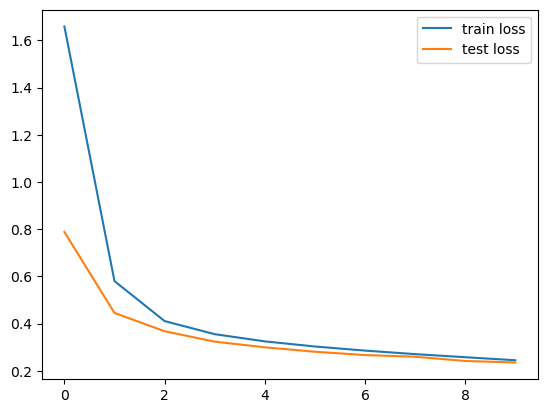

In [13]:
# This shows how losses reduce over time
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

## Calculate the accuracy

In [14]:
n_correct = 0.
n_total = 0.

for images, targets in train_loader:
    # Reshape
    images = images.view(-1, 784)
    # Forward pass
    outputs = model(images)

    # Get prediction
    # torch.max (over axis 1) returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # Update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.

for inputs, targets in test_loader:
    # Reshape
    # print(inputs.shape[0])
    inputs = inputs.view(-1, 784)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max (over axis 1) returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # Update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Training acc: {train_acc:.4f}, Testing acc: {test_acc:.4f}")

Training acc: 0.9317, Testing acc: 0.9336


### Plot confiusion matrix 

In [15]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title="Confision matrix", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalizatoin")

    print(cm)

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel("True target")
    plt.ylabel("Predicted target")
    plt.show()

Confusion matrix without normalizatoin
[[ 961    0    1    1    0    4    9    2    2    0]
 [   0 1109    3    2    0    2    3    2   14    0]
 [  12    6  951    5   12    1   14   11   19    1]
 [   1    1   26  926    0   20    2   11   19    4]
 [   1    2    5    0  936    0   12    2    7   17]
 [   9    1    4   28    5  792   16    4   26    7]
 [  10    3    5    0   10    8  920    0    2    0]
 [   3    7   29    4    7    0    0  959    3   16]
 [   8    5    6   18   10   19   14   10  881    3]
 [  12    8    1    8   51    8    1   11    8  901]]


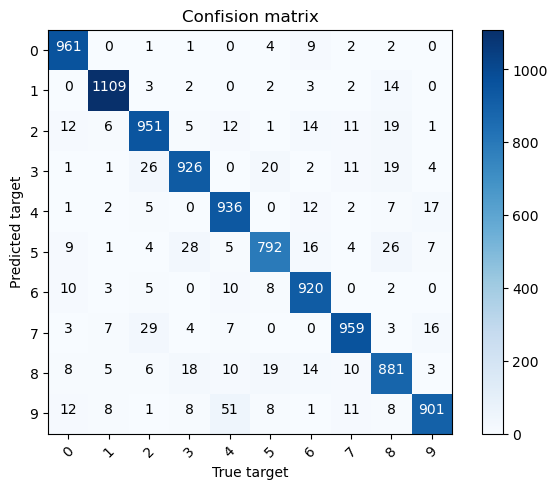

In [16]:
# Get all predictiones in an array and plot confusion matrix

x_test = testset.data.numpy()
y_test = testset.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
    # Reshape
    # print(inputs.shape[0])
    inputs = inputs.view(-1, 784)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max (over axis 1) returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # Update counts
    p_test = np.concatenate((p_test, predictions.numpy()))

cm = confusion_matrix(y_test, p_test)

plot_confusion_matrix(cm, list(range(10)))

Text(0.5, 1.0, 'True lable: 8 Predicted: 2')

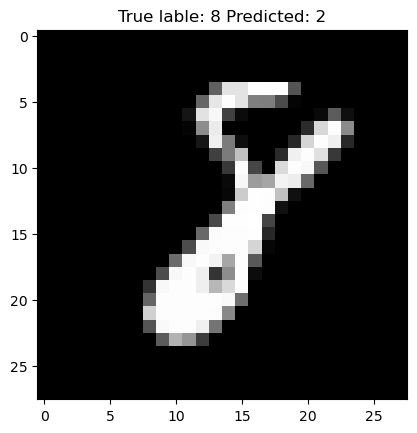

In [25]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)

plt.imshow(x_test[i], cmap="gray")
plt.title(f"True lable: {y_test[i]} Predicted: {int(p_test[i])}")